In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
from lime import lime_tabular

In [30]:
data = pd.read_csv('../data/stock_data_blk.csv')
data['Date'] = pd.to_datetime(data['Date'])
cutoff_date = '2023-09-01'
cutoff_date = pd.to_datetime(cutoff_date)
stock_data = data[data['Date'] <= cutoff_date]
future_data = data[data['Date'] > cutoff_date]

In [31]:
target = stock_data['Adj Close'].fillna(method='ffill').fillna(method='bfill')

/var/folders/jt/6cptnf497m1b19p6ksf_gz6c0000gn/T/ipykernel_81392/2283753820.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  target = stock_data['Adj Close'].fillna(method='ffill').fillna(method='bfill')


In [32]:
# Fit the ARIMA model
order = (5, 1, 0)  # You can adjust this based on the ACF and PACF plots
arima_model = ARIMA(target, order=order)
arima_model_fit = arima_model.fit()

In [33]:
# Initialize X_recent with the last available data
X_recent = stock_data['Adj Close'].values[-60:]  # Use the most recent 'Adj Close' values for ARIMA

predicted_prices = []

# Predict the next day's price using the most recent data
predicted_price = arima_model_fit.forecast(steps=1).iloc[0]  # Safely access the forecasted value
predicted_prices.append(predicted_price)

for i in range(9):  # Predict next 9 days
    # Append the predicted price to X_recent (maintaining the rolling window)
    X_recent = np.append(X_recent[1:], predicted_price)  # Remove the oldest value and add the predicted price
    
    # Fit ARIMA model on the updated X_recent and forecast
    arima_model_next = ARIMA(X_recent, order=order).fit()
    predicted_price = np.array(arima_model_next.forecast(steps=1))[0]  # Safely access the forecasted value
    predicted_prices.append(predicted_price)


In [34]:
# Get actual prices for comparison
actual_prices = future_data['Adj Close'][:10].values
dates = future_data['Date'][:10]

# Create a dataframe to compare actual and predicted prices
data = pd.DataFrame({
    'Date': dates,
    'actual price': actual_prices,
    'predicted price': predicted_prices
})

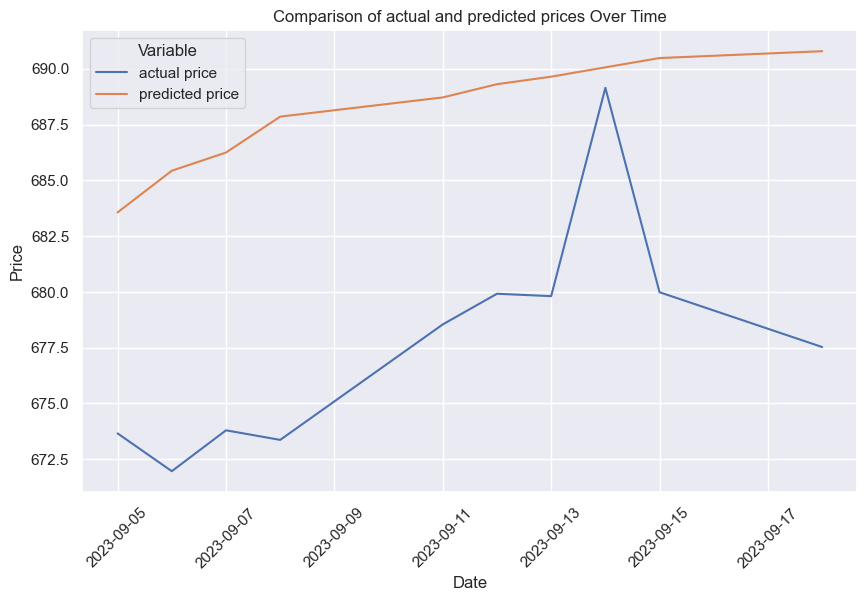

In [35]:
# Reshape data for plotting
data_long = pd.melt(data, id_vars=['Date'], value_vars=['actual price', 'predicted price'], var_name='Variable', value_name='Value')

# Plot comparison of actual and predicted prices over time
sns.set_theme()
plt.figure(figsize=(10, 6))
sns.lineplot(data=data_long, x='Date', y='Value', hue='Variable')
plt.title('Comparison of actual and predicted prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.show()

In [36]:
rmse = sqrt(mean_squared_error(data['actual price'], data['predicted price']))
print(f'RMSE: {rmse}')

RMSE: 11.047945992059825


In [37]:
# LIME Explanations for ARIMA
explainer = lime_tabular.LimeTabularExplainer(
    training_data=np.array(target.values).reshape(-1, 1),
    feature_names=['Adj Close'],
    mode='regression'
)

# Function to make predictions from ARIMA
def predict_fn_arima(data):
    # Make sure to reshape input for LIME
    forecast_results = []
    for i in range(len(data)):
        arima_model_next = ARIMA(data[i], order=order).fit()
        forecast_results.append(arima_model_next.forecast(steps=1)[0])
    return np.array(forecast_results)

# Explain an individual prediction (using the first prediction from ARIMA)
exp = explainer.explain_instance(data_row=np.array([target.values[-1]]).reshape(1, -1), predict_fn=predict_fn_arima)

# Visualize the explanation in the notebook
exp.show_in_notebook(show_table=True)

/Users/arjun/Code/FYP/LSTM-Model/venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/arjun/Code/FYP/LSTM-Model/venv/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/arjun/Code/FYP/LSTM-Model/venv/lib/python3.12/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/arjun/Code/FYP/LSTM-Model/venv/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


LinAlgError: Schur decomposition solver error.